# Exponential smoothing

In [1]:
import sys
from utils import *

In [2]:
import warnings
warnings.simplefilter('ignore')

## Simple exponential smoothing

In [3]:
global_economy = (pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibbledata\global_economy.csv', parse_dates=['Year'])
.rename(columns={'Year':'Date'})
.pipe(compute, lambda x: dict(Pop = x.Population / 1e6)))

In [4]:
algeria_economy = (global_economy
                   .query("Country == 'Algeria'")
                   .set_index('Date')
                   .pipe(set_freq))

In [5]:
algeria_economy.head()

,Country,Code,GDP,Growth,CPI,Imports,Exports,Population,Pop
Date,,,,,,,,,
1960-01-01,Algeria,DZA,2.723649e+09,NaN,NaN,67.143632,39.043173,11124888.0,11.124888
1961-01-01,Algeria,DZA,2.434777e+09,-13.605441,NaN,67.503771,46.244557,11404859.0,11.404859
1962-01-01,Algeria,DZA,2.001469e+09,-19.685042,NaN,20.818647,19.793873,11690153.0,11.690153
1963-01-01,Algeria,DZA,2.703015e+09,34.313729,NaN,36.825515,24.684682,11985136.0,11.985136
1964-01-01,Algeria,DZA,2.909352e+09,5.839413,NaN,29.439763,25.084059,12295970.0,12.295970


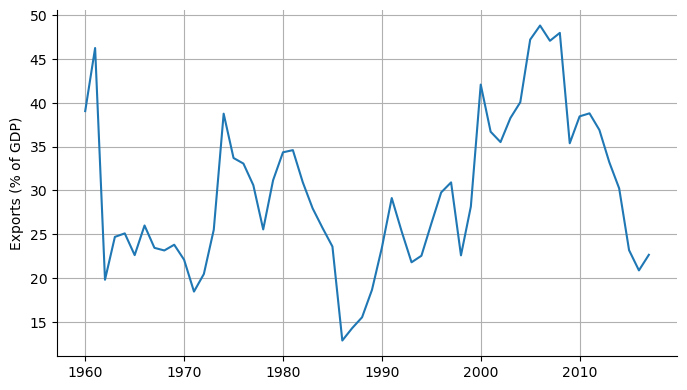

In [6]:
fig, ax = plt.subplots()
ax.plot(algeria_economy.Exports)
ax.set(ylabel='Exports (% of GDP)')
ax.grid()

### Algerian exports

In [7]:
Y = algeria_economy.Exports
X = Y.index
fit = sm.tsa.SimpleExpSmoothing(Y).fit()
fit.summary()

Dep. Variable:,Exports,No. Observations:,58
Model:,SimpleExpSmoothing,SSE,1995.536
Optimized:,True,AIC,209.217
Trend:,None,BIC,213.338
Seasonal:,None,AICC,209.972
Seasonal Periods:,None,Date:,"Fri, 21 Mar 2025"
Box-Cox:,False,Time:,08:24:00
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8395372,alpha,True
initial_level,39.043173,l.0,False


In [8]:
fit.fittedfcast.shape, fit.fittedvalues.shape

((59,), (58,))

In [9]:
def error_scale(percent):
    return stats.norm.isf((1 - percent/100) / 2)

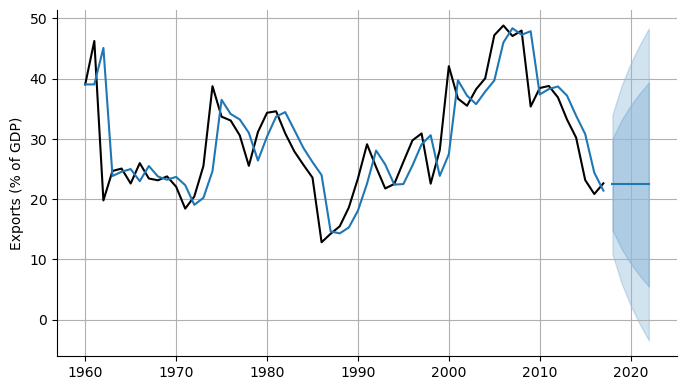

In [10]:
fig, ax = plt.subplots()

ax.plot(Y, 'k')
ax.plot(fit.fittedvalues)
sigma = (Y - fit.fittedvalues).std()

fcast = fit.forecast(5)
ax.plot(fcast, color='C0')
dy = sigma * np.sqrt(1+np.arange(len(fcast)))
s = error_scale(80)
ax.fill_between(fcast.index, fcast - s*dy, fcast + s*dy, color='C0', alpha=.2)
s = error_scale(95)
ax.fill_between(fcast.index, fcast - s*dy, fcast + s*dy, color='C0', alpha=.2)

ax.set(ylabel='Exports (% of GDP)')
ax.grid()

## Methods with trend

### Australian population

In [11]:
aus_economy = (global_economy
               .query("Code == 'AUS'")
               .set_index('Date')
               .pipe(set_freq))

In [12]:
fit = sm.tsa.ExponentialSmoothing(aus_economy.Pop, trend='add').fit()
fit.summary()

Dep. Variable:,Pop,No. Observations:,58
Model:,ExponentialSmoothing,SSE,0.223
Optimized:,True,AIC,-314.493
Trend:,Additive,BIC,-306.251
Seasonal:,None,AICC,-312.846
Seasonal Periods:,None,Date:,"Fri, 21 Mar 2025"
Box-Cox:,False,Time:,08:24:00
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.3248176,beta,True


In [13]:
def summarize_holt(res):
    d = pd.DataFrame(dict(
        observation=res.data.orig_endog,
        level=res.level,
        season=res.season,
        forecast=res.fittedvalues))
    return d

In [14]:
summarize_holt(fit).iloc[np.r_[:5, -5:0]]

,observation,level,season,forecast
Date,,,,
1960-01-01,10.276477,10.276477,0.0,10.276487
1961-01-01,10.483000,10.483000,0.0,10.500205
1962-01-01,10.742000,10.742000,0.0,10.701139
1963-01-01,10.950000,10.950000,0.0,10.973412
1964-01-01,11.167000,11.167000,0.0,11.173807
2013-01-01,23.145901,23.145901,0.0,23.094801
2014-01-01,23.504138,23.504138,0.0,23.514825
2015-01-01,23.850784,23.850784,0.0,23.869591
2016-01-01,24.210809,24.210809,0.0,24.210128


### Australian population

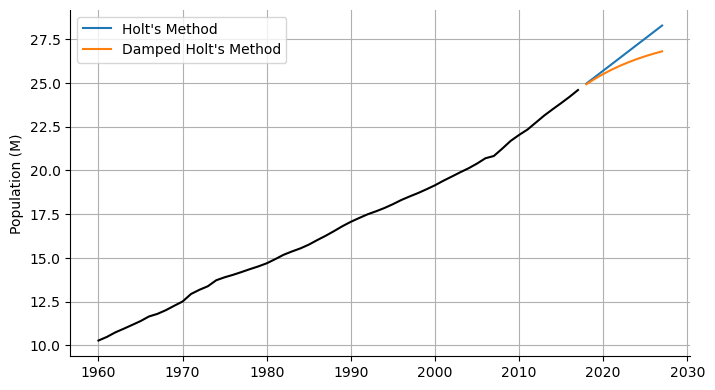

In [15]:
fig, ax = plt.subplots()
ax.plot(aus_economy.Pop, 'k')

fit = sm.tsa.ExponentialSmoothing(aus_economy.Pop, trend='add').fit()
ax.plot(fit.forecast(10), label="Holt's Method")

fit = sm.tsa.ExponentialSmoothing(aus_economy.Pop, trend='add', damped=True).fit(damping_slope=.9)
ax.plot(fit.forecast(10), label="Damped Holt's Method")

ax.legend(loc='upper left')
ax.set(ylabel='Population (M)')
ax.grid()

### Internet usage

In [16]:
www_usage = rdatasets.data('datasets', 'WWWusage')

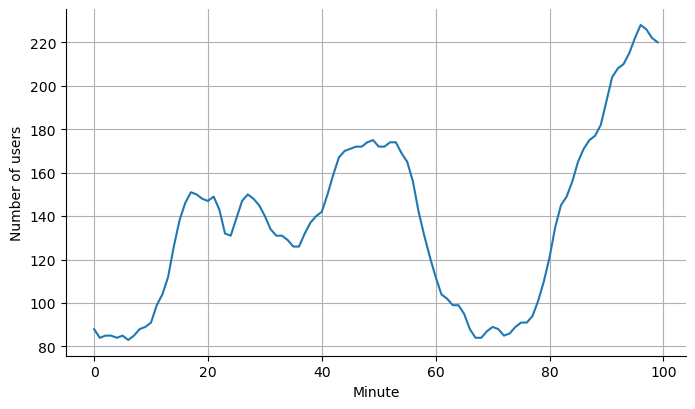

In [17]:
ax = www_usage.value.plot()
ax.set(xlabel='Minute', ylabel='Number of users')
ax.grid()

In [18]:
Y = www_usage.value
ms = dict(SES = sm.tsa.statespace.ExponentialSmoothing(Y).fit(),
     Holt = sm.tsa.statespace.ExponentialSmoothing(Y, trend='add').fit(),
     DampedHolt = sm.tsa.statespace.ExponentialSmoothing(Y, trend='add', damped_trend=True).fit(),)

In [19]:
tsaccuracy(Y, ms)

,RMSE,MAE,MAPE,MASE
SES,5.771104,4.480575,3.368179,NaN
Holt,3.569613,2.920306,2.267657,NaN
DampedHolt,3.390966,2.714095,2.108654,NaN


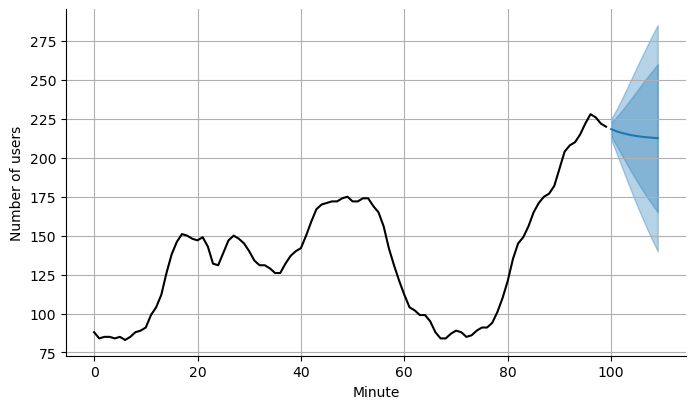

In [20]:
fig, ax = plt.subplots()
ax.plot(Y, 'k')

m = ms['DampedHolt']
fc = m.get_forecast(10)
ax.plot(fc.predicted_mean)
    
pint = fc.conf_int(alpha=.05)
ax.fill_between(pint.index, pint['lower value'], pint['upper value'], alpha=.33, color='C0')
pint = fc.conf_int(alpha=.2)
ax.fill_between(pint.index, pint['lower value'], pint['upper value'], alpha=.33, color='C0')

ax.set(xlabel='Minute', ylabel='Number of users')
ax.grid()

## Methods with seasonality

### Domestic overnight trips in Australia

In [21]:
tourism = (pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibble\tourism.csv')
           .pipe(compute, lambda x: dict(
               date=pd.to_datetime(x.Quarter.str.replace(' ', '')))))

In [22]:
aus_holidays = (tourism
                .query("Purpose == 'Holiday'")
                .groupby('date'.split())
                .Trips.sum()
                .reset_index()
                .set_index('date')
                .pipe(set_freq))
aus_holidays

,Trips
date,
1998-01-01,11806.037622
1998-04-01,9275.662074
1998-07-01,8642.488590
1998-10-01,9299.523781
1999-01-01,11172.027056
...,...
2016-10-01,10084.964670
2017-01-01,12406.418863
2017-04-01,10471.197262


In [23]:
Y = aus_holidays.Trips
m_add = sm.tsa.ExponentialSmoothing(Y, trend='add', seasonal='add').fit()
m_mul = sm.tsa.ExponentialSmoothing(Y, trend='mul', seasonal='mul').fit()

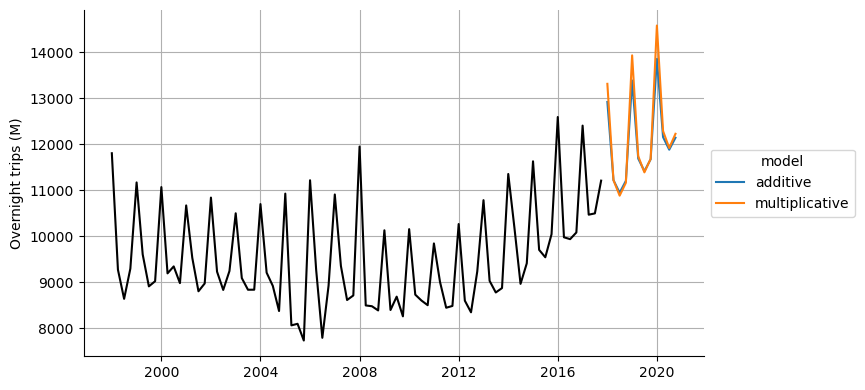

In [24]:
fig, ax = plt.subplots()
ax.plot(Y, 'k')

fc = m_add.forecast(3*4)
ax.plot(fc, label='additive')

fc = m_mul.forecast(3*4)
ax.plot(fc, label='multiplicative')

ax.set(ylabel='Overnight trips (M)')
ax.legend(title='model', **legend_right)
ax.grid()

In [25]:
m_add.params_formatted

,name,param,optimized
smoothing_level,alpha,0.242420,True
smoothing_trend,beta,0.147278,True
smoothing_seasonal,gamma,0.033623,True
initial_level,l.0,9724.101805,True
initial_trend,b.0,-36.940482,True
initial_seasons.0,s.0,1498.006999,True
initial_seasons.1,s.1,-271.373935,True
initial_seasons.2,s.2,-682.078776,True
initial_seasons.3,s.3,-524.700485,True


In [26]:
m_mul.params_formatted

,name,param,optimized
smoothing_level,alpha,0.217143,True
smoothing_trend,beta,0.133626,True
smoothing_seasonal,gamma,0.062629,True
initial_level,l.0,9704.028561,True
initial_trend,b.0,0.999949,True
initial_seasons.0,s.0,1.179798,True
initial_seasons.1,s.1,0.980663,True
initial_seasons.2,s.2,0.939027,True
initial_seasons.3,s.3,0.953205,True


In [27]:
s_add = summarize_holt(m_add)
s_mul = summarize_holt(m_mul)

In [28]:
s_add.head()

,observation,level,season,forecast
date,,,,
1998-01-01,11806.037622,9837.672663,1518.882314,11185.168323
1998-04-01,9275.662074,9756.024391,-280.649207,9551.525313
1998-07-01,8642.488590,9632.776829,-695.757655,9049.322980
1998-10-01,9299.523781,9649.529884,-516.947240,9068.928389
1999-01-01,11172.027056,9626.985666,1520.043300,11137.497254


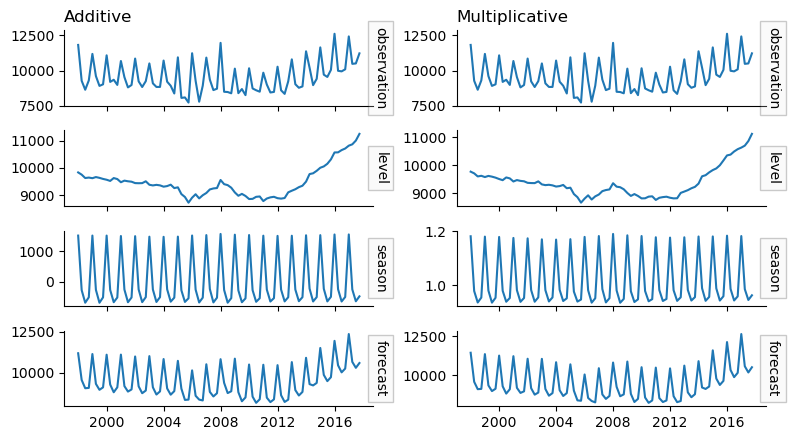

In [29]:
fig, axs = plt.subplots(4, 2, sharex=True)
for (j, s) in enumerate((s_add, s_mul)):
    for (i, field) in enumerate(s_add.columns):
        ax = axs[i, j]
        ax.plot(s[field])
        rlabel(ax, field)
axs[0, 0].set_title('Additive', size='large')
axs[0, 1].set_title('Multiplicative', size='large')
plt.tight_layout()

### Holt-Winters method with daily data

In [30]:
sth_cross_ped = d = pd.read_csv(r'C:\Users\machr\Desktop\Python\Code\Forecasting Principles and Practice 3\fpp3-data-main\tsibble\pedestrian.csv')
sth_cross_ped = (d.assign(Date_Time=pd.to_datetime(d.Date_Time).dt.tz_localize(None))
 .query("Sensor == 'Southern Cross Station'")
 .query("Date_Time >= '2016-07-01'")
 .set_index('Date_Time')
 .resample('1d').sum()
 .pipe(set_freq))
sth_cross_ped

,Sensor,Date,Time,Count
Date_Time,,,,
2016-07-01,Southern Cross StationSouthern Cross StationSo...,2016-07-012016-07-012016-07-012016-07-012016-0...,276,11712
2016-07-02,Southern Cross StationSouthern Cross StationSo...,2016-07-022016-07-022016-07-022016-07-022016-0...,276,2361
2016-07-03,Southern Cross StationSouthern Cross StationSo...,2016-07-032016-07-032016-07-032016-07-032016-0...,276,8203
2016-07-04,Southern Cross StationSouthern Cross StationSo...,2016-07-042016-07-042016-07-042016-07-042016-0...,276,17352
2016-07-05,Southern Cross StationSouthern Cross StationSo...,2016-07-052016-07-052016-07-052016-07-052016-0...,276,16265
...,...,...,...,...
2016-12-27,Southern Cross StationSouthern Cross StationSo...,2016-12-272016-12-272016-12-272016-12-272016-1...,276,3446
2016-12-28,Southern Cross StationSouthern Cross StationSo...,2016-12-282016-12-282016-12-282016-12-282016-1...,276,5577
2016-12-29,Southern Cross StationSouthern Cross StationSo...,2016-12-292016-12-292016-12-292016-12-292016-1...,276,4956


In [31]:
split = '2016-08-01'
dtrain, dtest = sth_cross_ped[:split], sth_cross_ped[split:'2016-09-01']

In [32]:
m = sm.tsa.ExponentialSmoothing(dtrain.Count, trend='add', damped=True, seasonal='mul').fit()

In [33]:
RMSE(dtrain.Count, m.fittedvalues)

449.5721166319321

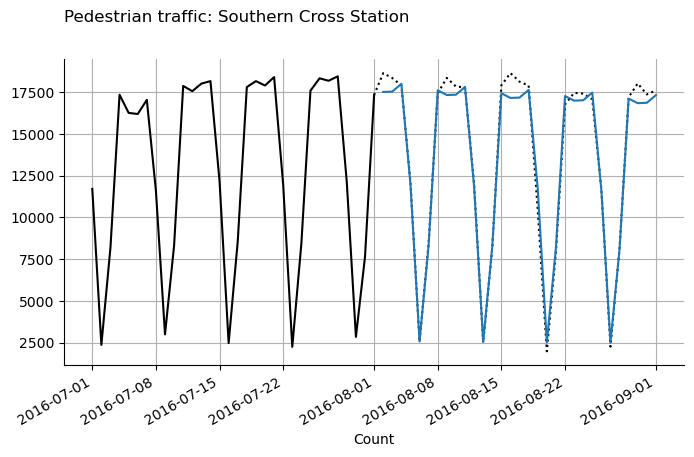

In [34]:
fig, ax = plt.subplots()
ax.plot(dtrain.Count, 'k')
ax.plot(dtest.Count, 'k:')

fc = m.forecast(31)
ax.plot(fc)
ax.set(xlabel='Count')
suptitle('Pedestrian traffic: Southern Cross Station')
fig.autofmt_xdate()
ax.grid()

In [35]:
RMSE(dtest.Count, fc)

605.4537097701551

In [36]:
m = sm.tsa.statespace.ExponentialSmoothing(dtrain.Count,
                                       trend=True,
                                       seasonal=7,
                                       damped_trend=True).fit()

In [37]:
RMSE(dtrain.Count, m.fittedvalues)

461.69612473366004

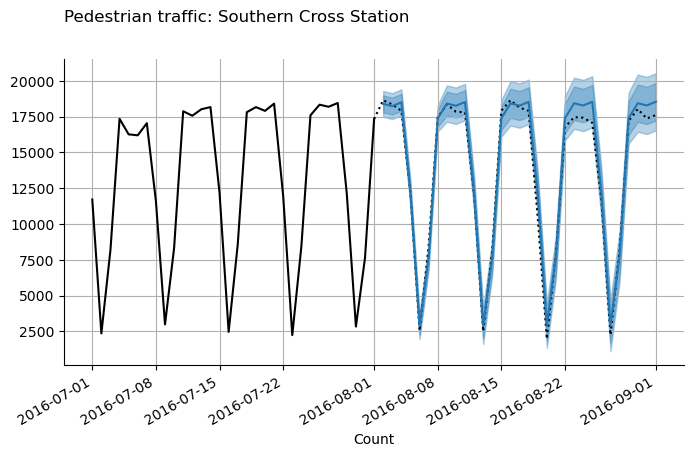

In [38]:
fig, ax = plt.subplots()
ax.plot(dtrain.Count, 'k')
ax.plot(dtest[:'2016-09-01'].Count, 'k:')

fc = m.get_forecast(31)
ax.plot(fc.predicted_mean)

ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, color='C0', alpha=.33)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, color='C0', alpha=.33)

ax.set(xlabel='Count')
suptitle('Pedestrian traffic: Southern Cross Station')
fig.autofmt_xdate()
ax.grid()

In [39]:
RMSE(dtest.Count, fc.predicted_mean)

667.515168604067

In [40]:
m = sm.tsa.statespace.ExponentialSmoothing(np.log1p(dtrain.Count),
                                       trend=True,
                                       seasonal=7,
                                       damped_trend=True).fit()

In [41]:
e1 = np.expm1

In [42]:
RMSE(dtrain.Count, e1(m.fittedvalues))

423.567261022736

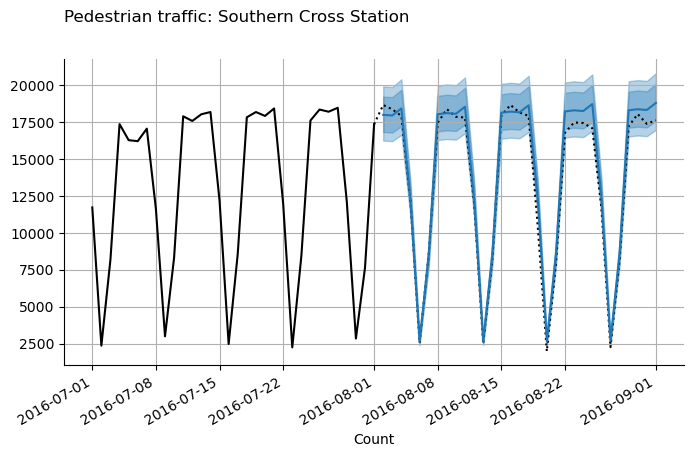

In [43]:
fig, ax = plt.subplots()
ax.plot(dtrain.Count, 'k')
ax.plot(dtest[:'2016-09-01'].Count, 'k:')

fc = m.get_forecast(31)
ax.plot(e1(fc.predicted_mean))

ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, e1(ci.lower), e1(ci.upper), color='C0', alpha=.33)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, e1(ci.lower), e1(ci.upper), color='C0', alpha=.33)

ax.set(xlabel='Count')
suptitle('Pedestrian traffic: Southern Cross Station')
fig.autofmt_xdate()
ax.grid()

In [44]:
RMSE(dtest.Count, e1(fc.predicted_mean))

758.6868294916903

### Forecasting with ETS models

In [45]:
Y = aus_holidays.Trips
m = sm.tsa.statespace.ExponentialSmoothing(Y, trend=True, seasonal=4, damped_trend=True).fit()

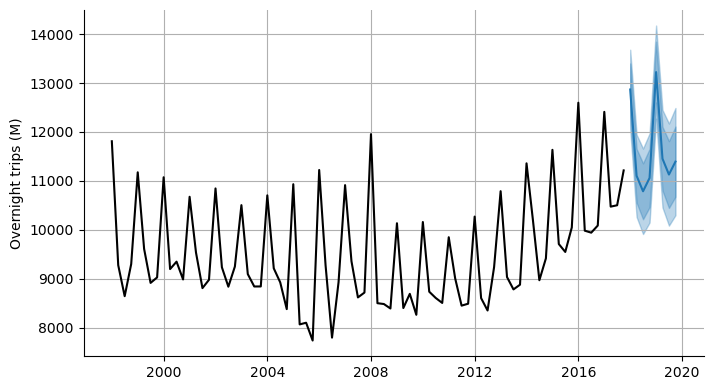

In [46]:
fig, ax = plt.subplots()
ax.plot(Y, 'k')

fc = m.get_forecast(8)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')

ax.set(ylabel='Overnight trips (M)')

ax.grid()